In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, zscore
from sklearn.preprocessing import RobustScaler
from sklearn.covariance import EllipticEnvelope
from typing import List, Dict, Tuple, Optional
import warnings
from scipy.stats import gaussian_kde

In [ ]:
class ExoplanetAnalysis:
    def __init__(self, df: pd.DataFrame, min_samples: int = 10):
        """
        Initialize ExoplanetAnalysis with enhanced outlier detection.
        
        Args:
            df (pd.DataFrame): Input DataFrame containing exoplanet data
            min_samples (int): Minimum number of samples required for correlation
        """
        self.df = df.copy()
        self.df_cleaned = None
        self.min_samples = min_samples
        self.outliers = {}
        self.outlier_scores = {}
        
        # Column definitions (same as before)
        self.main_columns = {
            'planet_properties': [
                'planet_period_x', 'semi_major_axis_x', 'planet_radius_x',
                'pl_bmasse', 'pl_orbeccen', 'pl_insol', 'pl_eqt'
            ],
            'star_properties': [
                'star_temperature_x', 'star_radius_x', 'star_mass_x',
                'st_met', 'st_logg', 'sy_dist'
            ]
        }
        
        self.log_transform_columns = [
            'planet_period_x', 'semi_major_axis_x', 'pl_bmasse',
            'planet_radius_x', 'pl_insol'
        ]

        self.valid_columns = (
            self.main_columns['planet_properties'] + 
            self.main_columns['star_properties']
        )

    def clean_data(self) -> pd.DataFrame:
        """
        
        Identifies columns that represent upper/lower limits and removes their numerical values 
        from correlation calculations by setting them to NaN.

        Returns:
        pd.DataFrame: Cleaned DataFrame
        """
        df_clean = self.df.copy()
    
        # Keywords indicating upper/lower limits
        limit_keywords = ['max', 'min', 'upper', 'lower', 'lim', 'ul', 'll', 'constraint', 'bound', '<', '>']
        
        # Identifying columns that match limit-related keywords
        limited_cols = [col for col in df_clean.columns if any(keyword in str(col).lower() for keyword in limit_keywords)]
        
        if limited_cols:
            print(f"Found {len(limited_cols)} columns containing limit values. Setting them to NaN.")
            for col in limited_cols:
                print(f"  - {col}")
            df_clean[limited_cols] = np.nan  # Set identified columns to NaN
            return df_clean
            
    def identify_outliers_multi_method(self, df: pd.DataFrame, column: str) -> Tuple[np.ndarray, Dict]:
        """
        Identify outliers using multiple methods and combine results.
        
        Args:
            df (pd.DataFrame): Input DataFrame
            column (str): Column to analyze
            
        Returns:
            Tuple[np.ndarray, Dict]: Combined outlier mask and method-specific scores
        """
        data = df[column].dropna()
        if len(data) < self.min_samples:
            return np.zeros(len(df), dtype=bool), {}
            
        scores = {}
        
        # Method 1: IQR
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        iqr_outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
        scores['iqr'] = iqr_outliers.astype(int)
        
        # Method 2: Modified Z-score
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mad = np.median(np.abs(data - np.median(data)))
            modified_zscores = 0.6745 * (data - np.median(data)) / mad
            zscore_outliers = np.abs(modified_zscores) > 3.5
            scores['zscore'] = zscore_outliers.astype(int)
        
        # Method 3: RobustScaler
        scaler = RobustScaler()
        scaled_values = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()
        robust_outliers = (np.abs(scaled_values) > 2)
        scores['robust'] = robust_outliers.astype(int)
        
        # Combine methods (vote counting)
        combined_scores = np.zeros(len(df))
        valid_idx = data.index
        combined_scores[valid_idx] = (
            scores['iqr'] + scores['zscore'] + scores['robust']
        ) / 3
        
        # Final outlier mask (if at least 2 methods agree)
        outlier_mask = combined_scores > 0.5
        
        return outlier_mask, scores

    def handle_outliers(self, df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
        """
        Handle outliers using winsorization and multiple detection methods.
        
        Args:
            df (pd.DataFrame): Input DataFrame
            columns (List[str]): Columns to process
            
        Returns:
            pd.DataFrame: DataFrame with handled outliers
        """
        df_handled = df.copy()
        
        for col in columns:
            if col not in df.columns:
                continue
                
            outlier_mask, method_scores = self.identify_outliers_multi_method(df, col)
            self.outliers[col] = outlier_mask
            self.outlier_scores[col] = method_scores
            
            # Calculate winsorization bounds
            data = df[col].dropna()
            if len(data) >= self.min_samples:
                lower_bound = np.percentile(data, 1)
                upper_bound = np.percentile(data, 99)
                
                # Winsorize outliers
                df_handled.loc[df[col] < lower_bound, col] = lower_bound
                df_handled.loc[df[col] > upper_bound, col] = upper_bound
                
                outlier_count = outlier_mask.sum()
                print(f"{col}:")
                print(f"  - Identified {outlier_count} ({outlier_count/len(df)*100:.1f}%) outliers")
                print(f"  - Winsorized at [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        return df_handled

    def apply_log_transforms(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply log transformations with improved handling and warnings.
        
        Args:
            df (pd.DataFrame): Input DataFrame
            
        Returns:
            pd.DataFrame: DataFrame with added log-transformed columns
        """
        df_transformed = df.copy()
        
        for column in self.log_transform_columns:
            if column in df.columns:
                total_count = df[column].count()
                valid_mask = df[column] > 0
                valid_count = valid_mask.sum()
                
                if valid_count < total_count:
                    warnings.warn(
                        f"Lost {total_count - valid_count} values "
                        f"({(1 - valid_count/total_count)*100:.1f}%) "
                        f"during log transform of {column} due to non-positive values"
                    )
                
                if valid_count >= self.min_samples:
                    df_transformed[f'{column}_log'] = np.log10(df.loc[valid_mask, column])
                    print(f"Created log10 transform of {column} with {valid_count} values")
        
        return df_transformed

    def calculate_correlation_safely(self, x: pd.Series, y: pd.Series) -> Tuple[float, float, int]:
        """
        Calculate correlation with safety checks.
        
        Args:
            x (pd.Series): First variable
            y (pd.Series): Second variable
            
        Returns:
            Tuple[float, float, int]: Correlation coefficient, p-value, and sample size
        """
        # Remove NaN values
        mask = ~(x.isna() | y.isna())
        x, y = x[mask], y[mask]
        
        # Check minimum sample size
        if len(x) < self.min_samples:
            return np.nan, np.nan, len(x)
            
        # Check for constant values
        if x.nunique() <= 1 or y.nunique() <= 1:
            return np.nan, np.nan, len(x)
            
        try:
            corr, p_value = spearmanr(x, y)
            return corr, p_value, len(x)
        except:
            return np.nan, np.nan, len(x)

    def plot_relationship_enhanced(self, x_col: str, y_col: str, 
                                 log_x: bool = False, log_y: bool = False):
        """
        Plot relationship with enhanced visualization features.
        
        Args:
            x_col (str): Column name for x-axis
            y_col (str): Column name for y-axis
            log_x (bool): Whether to use log scale for x-axis
            log_y (bool): Whether to use log scale for y-axis
        """
        plt.figure(figsize=(12, 8))
        
        # Prepare data
        x_data = self.df_cleaned[x_col]
        y_data = self.df_cleaned[y_col]
        
        # Handle log transformations
        if log_x:
            x_data = x_data[x_data > 0]
            y_data = y_data[x_data.index]
            x_data = np.log10(x_data)
        if log_y:
            valid_y = y_data > 0
            x_data = x_data[valid_y]
            y_data = np.log10(y_data[valid_y])
        
        # Remove NaN values
        mask = ~(x_data.isna() | y_data.isna())
        x_data, y_data = x_data[mask], y_data[mask]
        
        if len(x_data) < self.min_samples:
            plt.text(0.5, 0.5, 'Insufficient data points', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.close()
            return
        
        # Calculate density for coloring
        xy = np.vstack([x_data, y_data])
        z = gaussian_kde(xy)(xy)
        
        # Sort points by density for better visualization
        idx = z.argsort()
        x_data, y_data, z = x_data[idx], y_data[idx], z[idx]
        
        # Create scatter plot with density coloring
        scatter = plt.scatter(x_data, y_data, c=z, s=50, alpha=0.5, cmap='viridis')
        plt.colorbar(scatter, label='Density')
        
        # Add regression line
        try:
            z = np.polyfit(x_data, y_data, 1)
            p = np.poly1d(z)
            plt.plot(x_data, p(x_data), "r--", alpha=0.8, label='Regression line')
        except:
            pass
        
        # Calculate correlations
        corr, p_value, n = self.calculate_correlation_safely(x_data, y_data)
        
        # Add detailed statistics
        stats_text = (
            f'Spearman ρ = {corr:.3f}\n'
            f'p-value = {p_value:.2e}\n'
            f'n = {n}'
        )
        plt.annotate(stats_text, xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle='round', fc='white', alpha=0.8))
        
        plt.xlabel(f'log₁₀({x_col})' if log_x else x_col)
        plt.ylabel(f'log₁₀({y_col})' if log_y else y_col)
        plt.title(f'Relationship between {y_col} and {x_col}')
        
        # Add grid and legend
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def run_analysis(self):
        """
        Run complete analysis pipeline with enhanced error handling.
        """
        try:
            print("Starting enhanced exoplanet data analysis...")
            
            # Clean data
            print("\n1. Cleaning data...")
            self.df_cleaned = self.clean_data()
            
            # Handle outliers
            print("\n2. Handling outliers...")
            self.df_cleaned = self.handle_outliers(self.df_cleaned, self.valid_columns)
            
            # Apply log transforms
            print("\n3. Applying log transformations...")
            self.df_cleaned = self.apply_log_transforms(self.df_cleaned)
            
            # Plot relationships
            print("\n4. Plotting key relationships...")
            key_relationships = [
                ('star_mass_x', 'planet_period_x', False, True),
                ('planet_radius_x', 'pl_bmasse', True, True),
                ('semi_major_axis_x', 'pl_eqt', True, False),
                ('star_temperature_x', 'planet_radius_x', False, True),
                ('pl_insol', 'pl_eqt', True, False)
            ]
            
            for x_col, y_col, log_x, log_y in key_relationships:
                if x_col in self.df_cleaned.columns and y_col in self.df_cleaned.columns:
                    print(f"\nAnalyzing relationship: {x_col} vs {y_col}")
                    self.plot_relationship_enhanced(x_col, y_col, log_x, log_y)
            
            print("\nAnalysis complete!")
            
        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            raise

Starting enhanced exoplanet data analysis...

1. Cleaning data...
Found 35 columns containing limit values. Setting them to NaN.
  - default_flag
  - pl_orbperlim
  - pl_orbsmaxerr1
  - pl_orbsmaxerr2
  - pl_orbsmaxlim
  - pl_radelim
  - pl_radjlim
  - pl_bmasselim
  - pl_bmassjlim
  - pl_orbeccenlim
  - pl_insollim
  - pl_eqtlim
  - st_tefflim
  - st_radlim
  - st_masslim
  - st_metlim
  - st_logglim
  - mass_error_min
  - mass_error_max
  - radius_error_min
  - radius_error_max
  - orbital_period_error_min
  - orbital_period_error_max
  - star_distance_error_min
  - star_distance_error_max
  - star_metallicity_x
  - star_metallicity_error_min
  - star_metallicity_error_max
  - star_mass_error_min
  - star_mass_error_max
  - star_radius_error_min
  - star_radius_error_max
  - star_teff_error_min
  - star_teff_error_max
  - star_metallicity_y

2. Handling outliers...
planet_period_x:
  - Identified 6667 (14.5%) outliers
  - Winsorized at [0.77, 2170.52]
semi_major_axis_x:
  - Identifie

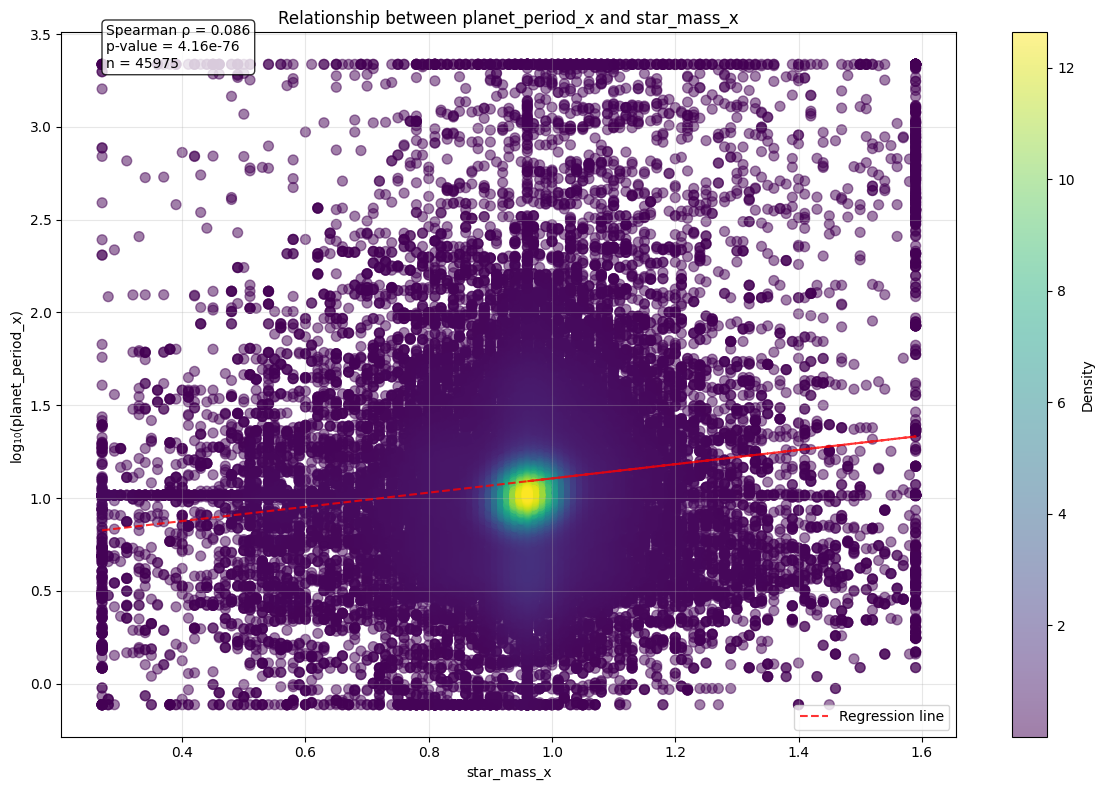


Analyzing relationship: planet_radius_x vs pl_bmasse


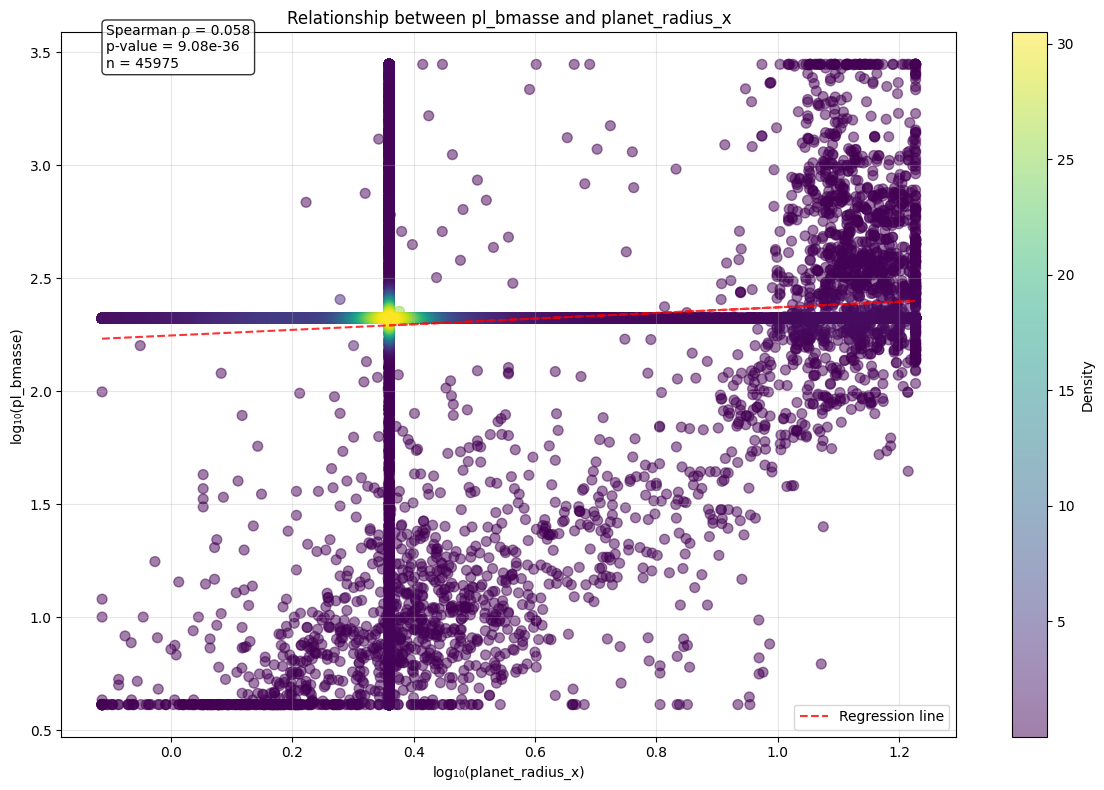


Analyzing relationship: semi_major_axis_x vs pl_eqt


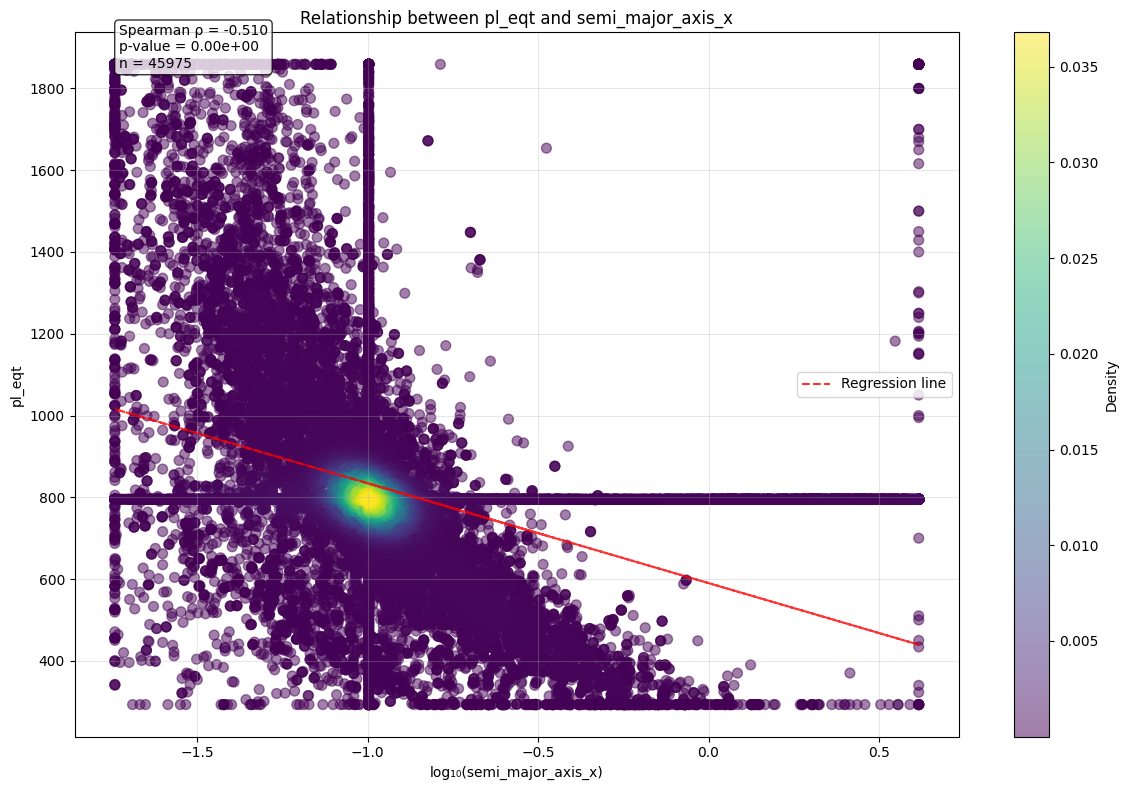


Analyzing relationship: star_temperature_x vs planet_radius_x


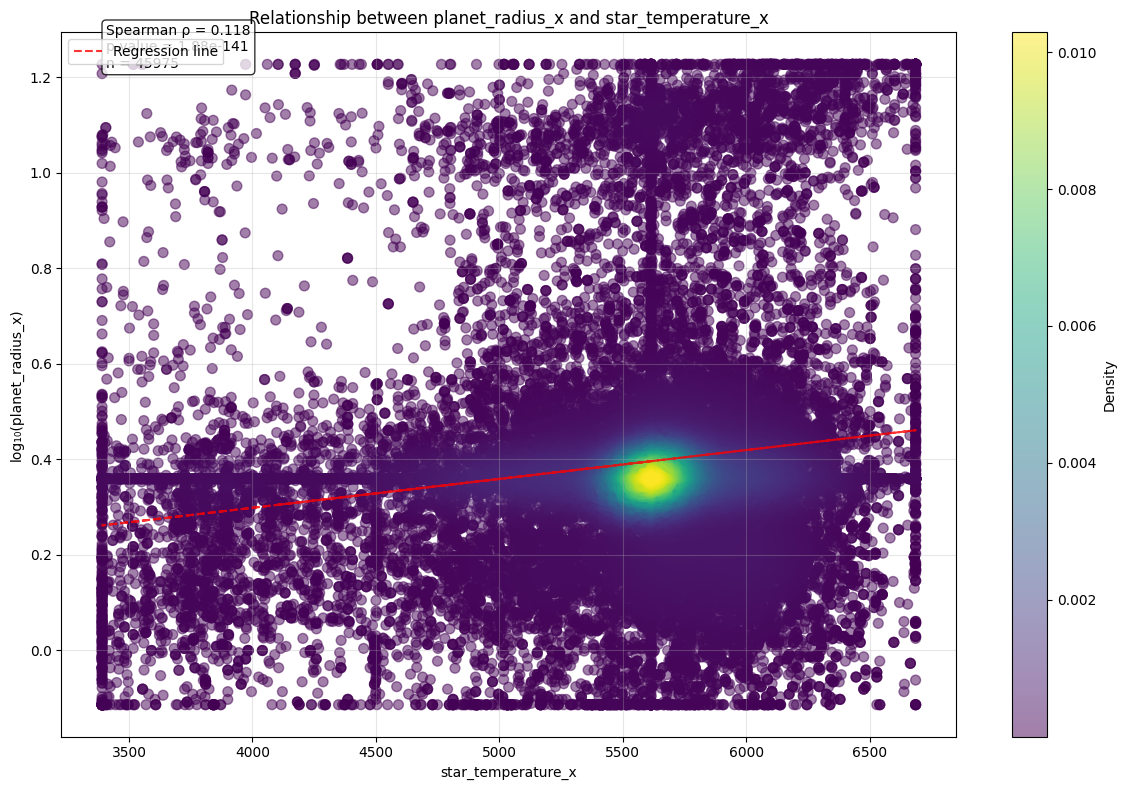


Analyzing relationship: pl_insol vs pl_eqt


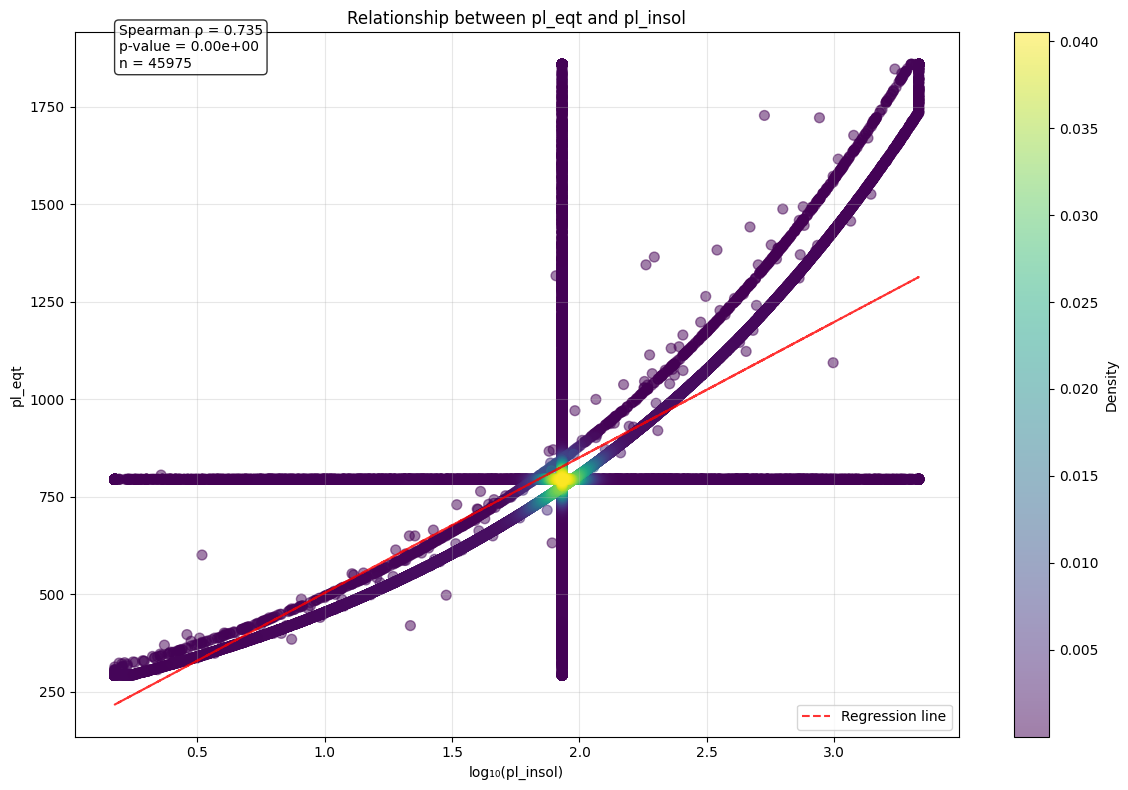


Analysis complete!


In [18]:
df = pd.read_csv('updated_exoplanets.csv')
analyzer = ExoplanetAnalysis(df, min_samples=10)
analyzer.run_analysis()